In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from tensorflow.keras.datasets import fashion_mnist

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 27s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


In [3]:
# Initialize SIFT
sift = cv2.SIFT_create()

def convert_to_uint8(image):
    if image.dtype == np.float32:
        image = np.clip(image, 0, 1) * 255
        image = image.astype(np.uint8)
    elif image.dtype == np.float64:
        image = np.clip(image, 0, 1) * 255
        image = image.astype(np.uint8)
    elif image.dtype == np.int32 or image.dtype == np.int64:
        image = np.clip(image, 0, 255)
        image = image.astype(np.uint8)
    return image

def extract_sift_features(images):
    descriptors_list = []
    valid_indices = []

    start_time = time.time()  # Start timing

    for idx, img in enumerate(images):
        if img is None:
            print(f"Warning: Image at index {idx} is not loaded correctly.")
            continue

        img = convert_to_uint8(img)

        try:
            img_gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        except cv2.error as e:
            print(f"Warning: Error converting image at index {idx} to RGB: {e}")
            continue

        if img_gray.dtype != np.uint8:
            print(f"Warning: Image at index {idx} has incorrect depth: {img_gray.dtype}")
            continue

        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Warning: No descriptors found for image at index {idx}.")

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    print(f"SIFT feature extraction runtime: {elapsed_time:.2f} seconds")

    return descriptors_list, valid_indices

# Extract SIFT features from train and validation images
train_descriptors_list, train_valid_indices = extract_sift_features(train_images)
test_descriptors_list, test_valid_indices = extract_sift_features(test_images)

SIFT feature extraction runtime: 37.18 seconds
SIFT feature extraction runtime: 6.26 seconds


In [4]:
# Flatten the list of descriptors for k-means clustering
all_descriptors = np.vstack(train_descriptors_list + test_descriptors_list)

# Perform k-means clustering to create the visual words
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(all_descriptors)

# Save the visual word vocabulary
vocabulary = kmeans.cluster_centers_

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
# Function to create BoW histograms
def create_bow_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        words = kmeans.predict(descriptors)
        histogram, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1), density=True)
        histograms.append(histogram)
    return np.array(histograms)

# Create BoW histograms for train and validation data
train_bow_histograms = create_bow_histograms(train_descriptors_list, kmeans)
test_bow_histograms = create_bow_histograms(test_descriptors_list, kmeans)

# Normalize features
scaler = StandardScaler()
train_bow_histograms = scaler.fit_transform(train_bow_histograms)
test_bow_histograms = scaler.transform(test_bow_histograms)

BoW SVM Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       944
           1       0.66      0.55      0.60       628
           2       0.36      0.38      0.37       954
           3       0.38      0.43      0.40       923
           4       0.38      0.50      0.43       973
           5       0.59      0.67      0.63       966
           6       0.28      0.09      0.14       932
           7       0.59      0.59      0.59       965
           8       0.60      0.61      0.60       958
           9       0.73      0.78      0.75       988

    accuracy                           0.52      9231
   macro avg       0.51      0.52      0.51      9231
weighted avg       0.51      0.52      0.51      9231

Confusion Matrix:
[[564  14  54  63  58  54  44  34  43  16]
 [  1 348  17 191  15  19   3  16  17   1]
 [ 22  25 360  62 282  69  40  28  55  11]
 [ 93  28  79 399  77  36  31  95  70  15]
 [ 22  15 198  53 49

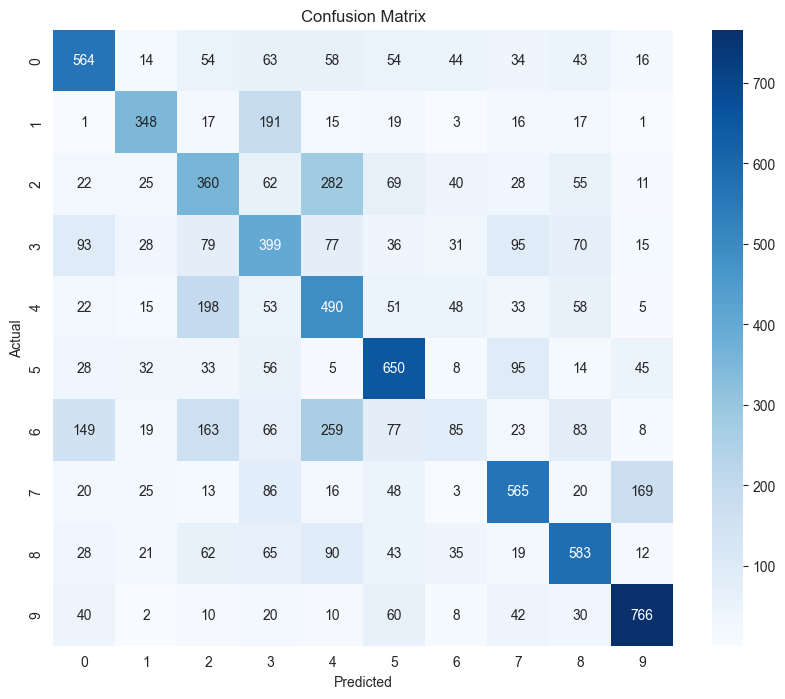

In [6]:
# Train an SVM classifier
svm = SVC(kernel='linear')
svm.fit(train_bow_histograms, train_labels[train_valid_indices])

# Predict and evaluate on validation data
test_predictions = svm.predict(test_bow_histograms)
print("BoW SVM Classification Report:")
print(classification_report(test_labels[test_valid_indices], test_predictions))

# Confusion Matrix
cm = confusion_matrix(test_labels[test_valid_indices], test_predictions)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

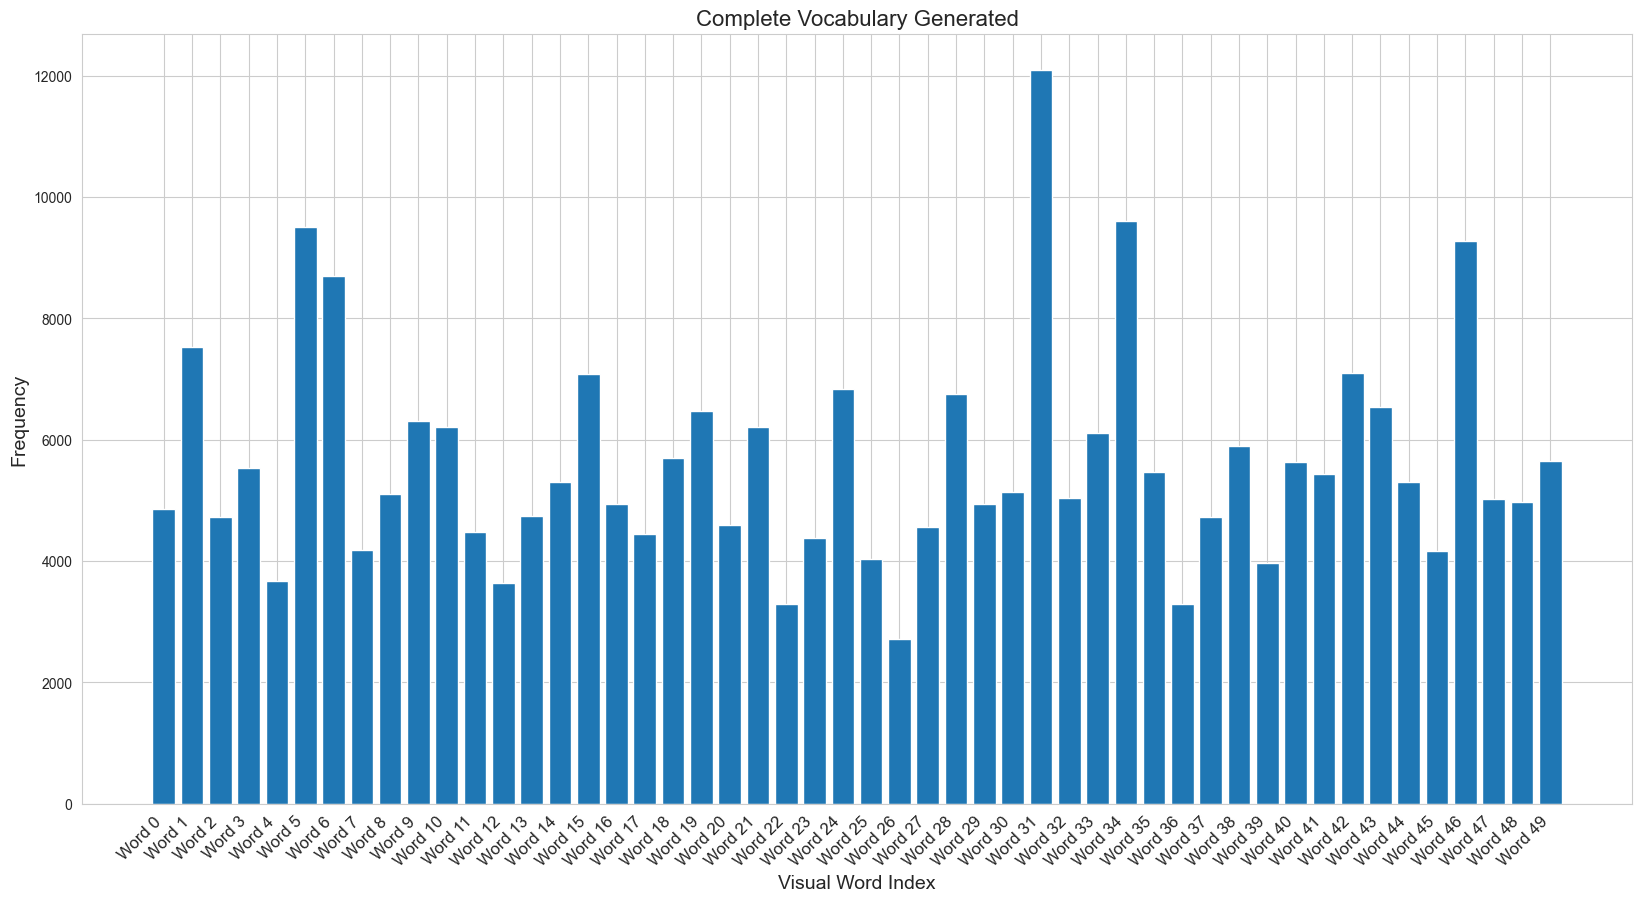

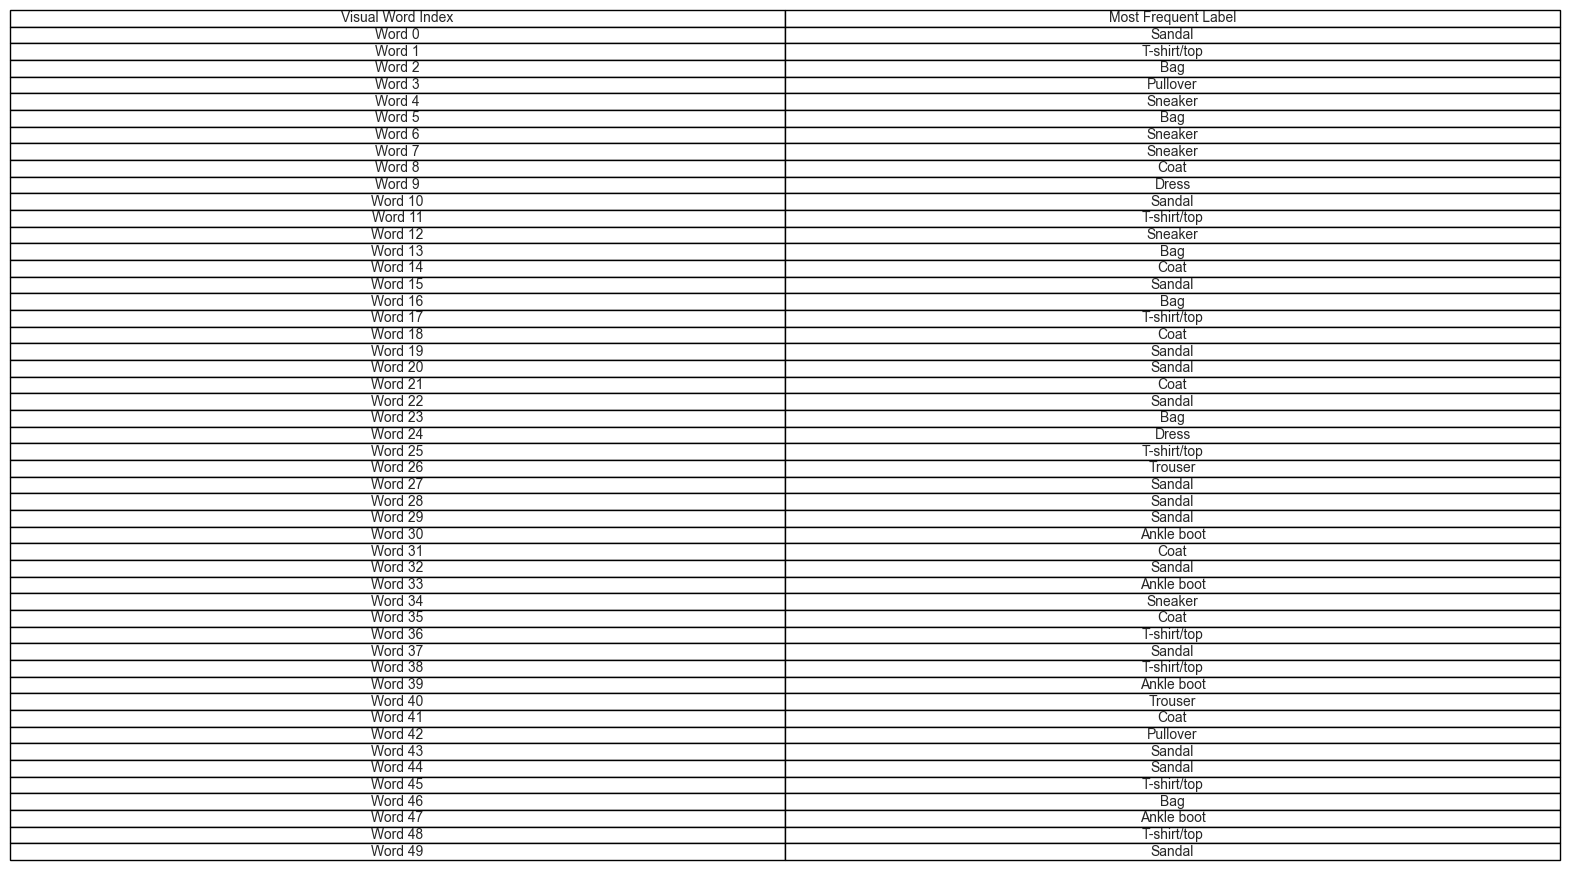

In [8]:
# Assign labels to visual words based on the most frequent class
visual_word_labels = {i: [] for i in range(num_clusters)}

for i, descriptors in enumerate(train_descriptors_list):
    words = kmeans.predict(descriptors)
    for word in words:
        visual_word_labels[word].append(train_labels[train_valid_indices[i]])

# Define label map for Fashion MNIST
label_map = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

# Create a label index map from index to class name
label_index_map = {v: k for k, v in label_map.items()}

# Find the most frequent class label for each visual word
visual_word_class_labels = {}
for word, labels in visual_word_labels.items():
    if labels:
        most_common_label = Counter(labels).most_common(1)[0][0]
        visual_word_class_labels[word] = label_map[most_common_label]
    else:
        visual_word_class_labels[word] = 'Unknown'

# Visualize the frequency of visual words with their labels
word_counts = np.bincount(kmeans.labels_)
visual_word_labels = [f'Word {i}' for i in range(num_clusters)]

# Adjust figure size for the plot
fig, ax = plt.subplots(figsize=(20, 10))
bars = ax.bar(range(num_clusters), word_counts)
ax.set_xlabel('Visual Word Index', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Complete Vocabulary Generated', fontsize=16)

# Keep x-axis labels simple
ax.set_xticks(range(num_clusters))
ax.set_xticklabels(visual_word_labels, rotation=45, ha='right', fontsize=12)

# Prepare the index/legend in a separate table
index_table = [[f'Word {i}', visual_word_class_labels[i]] for i in range(num_clusters)]

# Create a new figure for the index table
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=index_table, colLabels=['Visual Word Index', 'Most Frequent Label'], cellLoc='center', loc='center')

# Display both plots
plt.show()

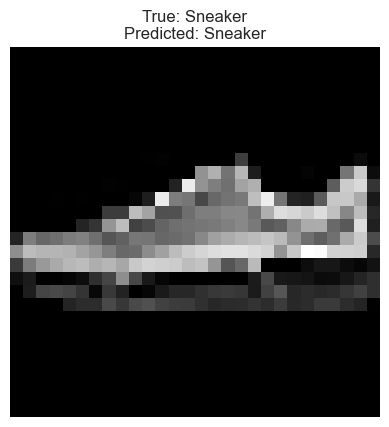

In [9]:
def display_image_and_prediction_by_index(data, labels, valid_indices, index, classifier, kmeans, scaler):
    if index not in valid_indices:
        print(f"Index {index} is not valid.")
        return

    img = data[index]
    label = labels[index]

    img = convert_to_uint8(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB for SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    if descriptors is not None and len(descriptors) > 0:
        words = kmeans.predict(descriptors)
        histogram, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1), density=True)
        histogram = scaler.transform([histogram])
        prediction = classifier.predict(histogram)[0]

        plt.imshow(img, cmap='gray')
        plt.title(f"True: {label_map[label]}\nPredicted: {label_map[prediction]}")
        plt.axis('off')
        plt.show()

# Display an image and its prediction
display_image_and_prediction_by_index(test_images, test_labels, test_valid_indices, 9, svm, kmeans, scaler)